<a href="https://colab.research.google.com/github/katjasit0815/Data-Science-academic-projects/blob/main/06_Face_expression_recognition%2C_distillation%2C_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pandas
# !pip install scikit-learn
# !pip install kagglehub
# !pip install matplotlib
# !pip install seaborn
# !pip install Pillow
# !pip install tqdm
# !pip install tf2onnx

In [ ]:
import os
# Скрываем информационные и предупреждающие логи TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TFLITE_XNNPACK_DELEGATE'] = '0'

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tf2onnx

from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import onnx
import tf2onnx
from onnx2keras import onnx_to_keras
from tabulate import tabulate
# Настройка GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        pass

In [ ]:
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/kat_sit/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1


In [ ]:
BASE_PATH = r'/home/kat_sit/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1/images'
TRAIN_DIR = os.path.join(BASE_PATH, "train")
VAL_DIR = os.path.join(BASE_PATH, "validation")

def scan_directory(data_dir):
    """Возвращает словарь классов и количества изображений в них,
       а также суммарное количество изображений в директории """

    class_counts = {}
    total_images = 0

    class_names = sorted(os.listdir(data_dir))

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len([
                name for name in os.listdir(class_path)
            ])
            class_counts[class_name] = count
            total_images += count

    return class_counts, total_images

train_counts, total_train = scan_directory(TRAIN_DIR)
val_counts, total_val = scan_directory(VAL_DIR)

print(f"--- Тренировочный набор (Total: {total_train}) ---")
for cls, count in train_counts.items():
    print(f"Класс {cls}: {count} изображений")

print(f"\n--- Валидационный набор (Total: {total_val}) ---")
for cls, count in val_counts.items():
    print(f"Класс {cls}: {count} изображений")

--- Тренировочный набор (Total: 28821) ---
Класс angry: 3993 изображений
Класс disgust: 436 изображений
Класс fear: 4103 изображений
Класс happy: 7164 изображений
Класс neutral: 4982 изображений
Класс sad: 4938 изображений
Класс surprise: 3205 изображений

--- Валидационный набор (Total: 7066) ---
Класс angry: 960 изображений
Класс disgust: 111 изображений
Класс fear: 1018 изображений
Класс happy: 1825 изображений
Класс neutral: 1216 изображений
Класс sad: 1139 изображений
Класс surprise: 797 изображений


Визуализируем распределение классов:

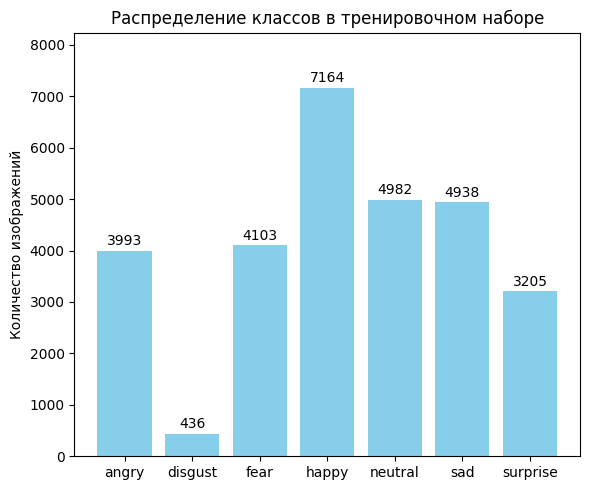

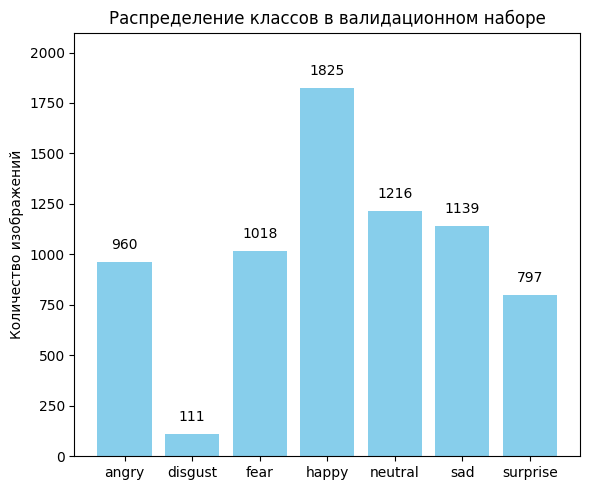

In [ ]:
def plot_class_distribution(counts, title):
    """ Визуализирует распределение классов """

    classes = list(counts.keys())
    counts_values = list(counts.values())

    plt.figure(figsize=(6, 5))
    bars = plt.bar(classes, counts_values, color='skyblue')

    plt.title(f'Распределение классов в {title}')
    y_limit = max(counts_values) * 1.15
    plt.ylim(0, y_limit)
    plt.ylabel('Количество изображений')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_class_distribution(train_counts, "тренировочном наборе")
print()
plot_class_distribution(val_counts, "валидационном наборе")

Как можно заметить, в датасете очень мало экземпляров класса disgust, учтем это на будущее и проверим, выучит ли модель класс disgust на хорошем уровне. Если нет - зададим веса, чтобы модель сильно штрафовалась за ошибку классификации класса disgust.

In [ ]:
def create_dataframe_from_dirs(data_dir):
    """
    Сканирует директорию, собирает полные пути к изображениям и их классы,
    и возвращает DataFrame.
    """
    all_paths = []
    all_classes = []
    class_names = sorted(os.listdir(data_dir))

    # Итерация по классам
    for class_name in tqdm(class_names):
        class_path = os.path.join(data_dir, class_name)

        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                full_path = os.path.join(class_path, filename)
                all_paths.append(full_path)
                all_classes.append(class_name)

    df = pd.DataFrame({
        'path': all_paths,
        'classes': all_classes
    })

    return df

In [ ]:
train_df = create_dataframe_from_dirs(TRAIN_DIR)
val_df = create_dataframe_from_dirs(VAL_DIR)

train_df.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1639.68it/s]


,path,classes
0,/home/kat_sit/.cache/kagglehub/datasets/jonath...,angry
1,/home/kat_sit/.cache/kagglehub/datasets/jonath...,angry
2,/home/kat_sit/.cache/kagglehub/datasets/jonath...,angry
3,/home/kat_sit/.cache/kagglehub/datasets/jonath...,angry
4,/home/kat_sit/.cache/kagglehub/datasets/jonath...,angry


In [ ]:
widths_tr, heights_tr, widths_val, heights_val = [],[],[],[]
for path in tqdm(train_df["path"]):
    width, height = Image.open(path).size
    widths_tr.append(width)
    heights_tr.append(height)

for path in tqdm(val_df["path"]):
    width, height = Image.open(path).size
    widths_val.append(width)
    heights_val.append(height)

100%|█████████████████████████████████████████████████████████████████████████████| 7066/7066 [00:01<00:00, 4070.32it/s]


In [ ]:
print(f'Уникальные расширения изображений в train_df: {set(widths_tr), set(heights_tr)}')
print(f'Уникальные расширения изображений в val_df: {set(widths_val), set(heights_val)}')

Уникальные расширения изображений в train_df: ({48}, {48})
Уникальные расширения изображений в val_df: ({48}, {48})


(48, 48)


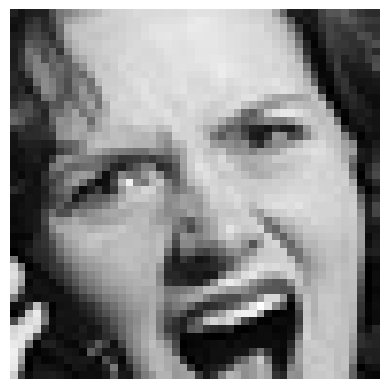

In [ ]:
img = np.asarray(Image.open(train_df['path'][0]))
plt.axis('off')
plt.imshow(img, cmap='gray')
print(img.shape)

In [ ]:
def plot_species(df, emotion_name, title):
    plt.figure(figsize = (12,12))
    species_df = df[df['classes'] == emotion_name].reset_index(drop = True)
    plt.suptitle(f"Случайные изображения класса {emotion_name} из датасета {title}",
        fontsize=10)
    for idx,i in enumerate(np.random.choice(species_df['path'],8)):
        plt.subplot(8,8,idx+1)
        image_path = i
        img = Image.open(image_path)
        img = img.resize((224,224))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

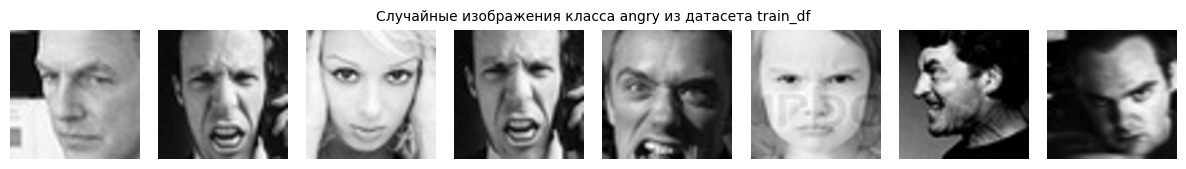

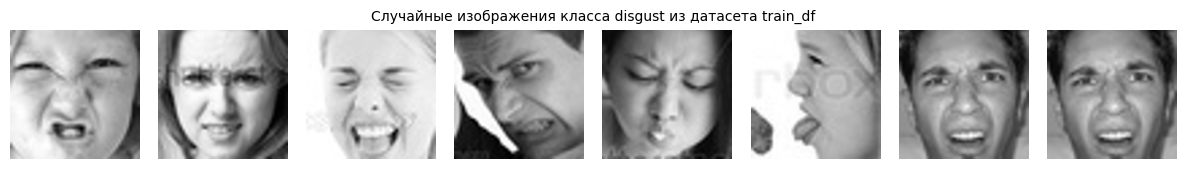

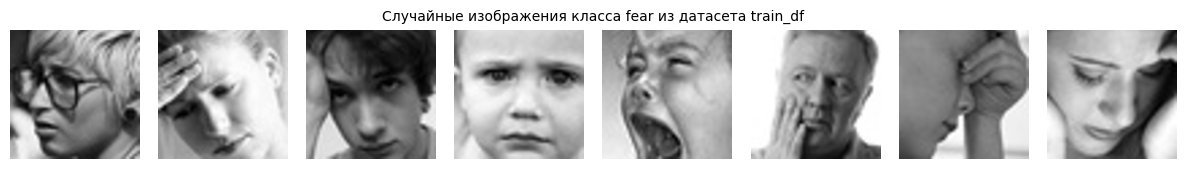

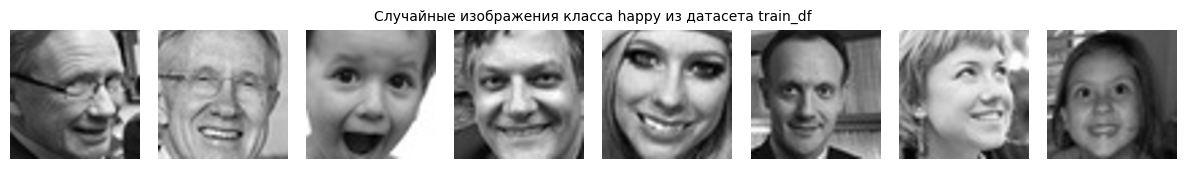

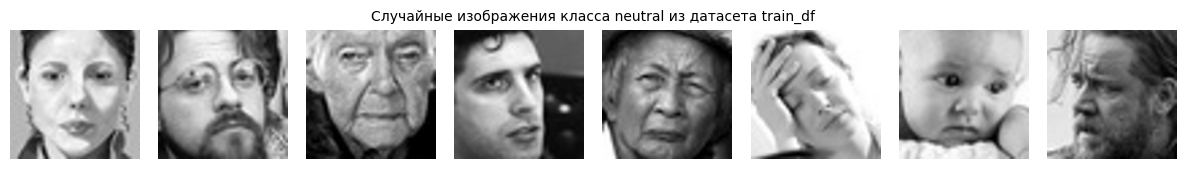

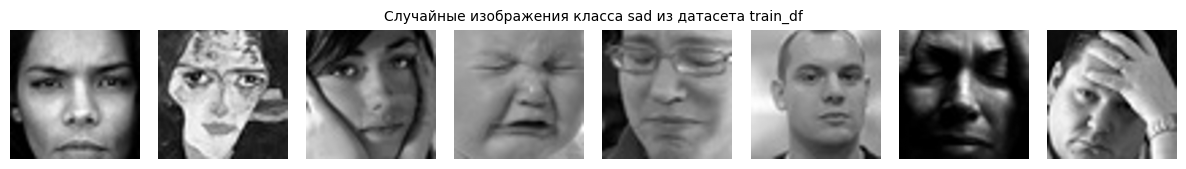

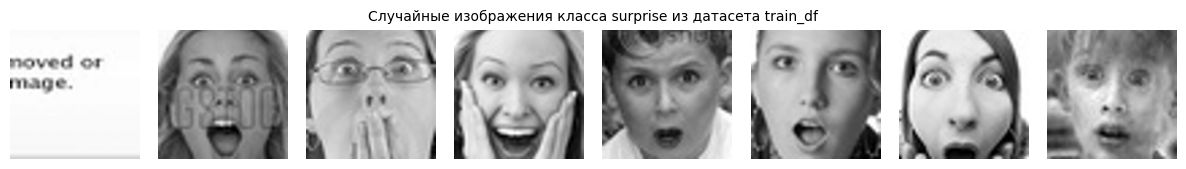

In [ ]:
for emotion_name in train_df['classes'].unique():
    plot_species(train_df, emotion_name,'train_df')

## Preprocessing данных

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 7
AUTOTUNE = tf.data.AUTOTUNE

label_encoder = LabelEncoder()
label_encoder.fit(train_df['classes'])
numeric_labels = label_encoder.transform(train_df['classes'])
numeric_labels_val = label_encoder.transform(val_df['classes'])

In [ ]:
def decode_and_resize(image_path, label):
    """Загружает изображение и изменяет его размер"""

    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32)

    return img, label

In [ ]:
data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.2),
layers.RandomZoom(0.2),
layers.RandomContrast(0.1),
])

I0000 00:00:1766502608.635135    1569 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9554 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
NUM_CPU_CORES = os.cpu_count()
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_df['path'], numeric_labels))
    .shuffle(buffer_size=20000)
    .map(decode_and_resize, num_parallel_calls=NUM_CPU_CORES)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

def val_preprocess(file_path, label):
    img, label = decode_and_resize(file_path, label)
    return img, label

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_df['path'], numeric_labels_val))
    .map(val_preprocess, num_parallel_calls=NUM_CPU_CORES)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
WORKING_DIR = '.'

CHECKPOINT_SUBDIR = 'model_checkpoints'
CHECKPOINT_DIR = os.path.join(WORKING_DIR, CHECKPOINT_SUBDIR)

checkpoint_filename = 'best_model_EfficientNetB0.weights.h5'
checkpoint_filepath = os.path.join(CHECKPOINT_DIR, checkpoint_filename)

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Файлы будут сохраняться в: {os.path.abspath(CHECKPOINT_DIR)}")
print(f"Полный путь к файлу весов: {os.path.abspath(checkpoint_filepath)}")

Файлы будут сохраняться в: /home/kat_sit/model_checkpoints
Полный путь к файлу весов: /home/kat_sit/model_checkpoints/best_model_EfficientNetB0.weights.h5


In [ ]:
callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss',mode='min',
    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]

In [ ]:
base_model_b0 = keras.applications.EfficientNetB0(
                                       include_top=False,
                                       weights="imagenet",
                                       input_shape=(IMG_SIZE,IMG_SIZE,3),
                                       )
base_model_b0.trainable = False

# Собираем новую модель с новой головой
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input)(x)
x = base_model_b0(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model_b0 = tf.keras.Model(inputs, outputs)

checkpoint_filename = 'best_model_EfficientNetB0.weights.h5'
checkpoint_filepath = os.path.join(CHECKPOINT_DIR, checkpoint_filename)

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

model_b0.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
history_b0 = model_b0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_1,
    verbose=1
)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.3557 - loss: 1.6296 - val_accuracy: 0.4023 - val_loss: 1.5464 - learning_rate: 5.0000e-04
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - accuracy: 0.4206 - loss: 1.5145 - val_accuracy: 0.4374 - val_loss: 1.4822 - learning_rate: 5.0000e-04
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.4392 - loss: 1.4745 - val_accuracy: 0.4639 - val_loss: 1.4511 - learning_rate: 5.0000e-04
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.4506 - loss: 1.4484 - val_accuracy: 0.4670 - val_loss: 1.4149 - learning_rate: 5.0000e-04
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.4588 - loss: 1.4308 - val_accuracy: 0.4764 - val_loss: 1.4034 - learning_rate: 5.0000e-04
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.4650 - loss: 1.4165 - val_accuracy: 0.4809 - val_loss: 1.3865 - learning_rate: 5.0000e-04
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/ste

## Fine tuning модели

In [ ]:
model_b0.load_weights(checkpoint_filepath)

base_model_b0.trainable = True
for layer in base_model_b0.layers[:-40]:
    layer.trainable = False
fine_tune_learning_rate = 1e-5

model_b0.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=fine_tune_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

fine_tune_checkpoint_filename = 'best_model_EfficientNetB0_fine_tuned.weights.h5'
fine_tune_checkpoint_filepath = os.path.join(CHECKPOINT_DIR, fine_tune_checkpoint_filename)

callbacks_2 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=fine_tune_checkpoint_filepath, monitor='val_loss',mode='min',
    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
    ]

fine_tune_epochs = 100
epochs_learned = 23
total_epochs = epochs_learned + fine_tune_epochs

In [ ]:
history_b0_fine_tune = model_b0.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=epochs_learned,
    validation_data=val_ds,
    callbacks=callbacks_2,
    verbose=1
)

Epoch 24/123
451/451 ━━━━━━━━━━━━━━━━━━━━ 60s 105ms/step - accuracy: 0.3766 - loss: 1.6311 - val_accuracy: 0.4691 - val_loss: 1.4325 - learning_rate: 1.0000e-05
Epoch 25/123
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.4405 - loss: 1.4834 - val_accuracy: 0.4909 - val_loss: 1.3571 - learning_rate: 1.0000e-05
Epoch 26/123
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.4585 - loss: 1.4215 - val_accuracy: 0.5103 - val_loss: 1.3058 - learning_rate: 1.0000e-05
Epoch 27/123
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.4766 - loss: 1.3793 - val_accuracy: 0.5255 - val_loss: 1.2727 - learning_rate: 1.0000e-05
Epoch 28/123
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.4880 - loss: 1.3532 - val_accuracy: 0.5330 - val_loss: 1.2479 - learning_rate: 1.0000e-05
Epoch 29/123
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.4998 - loss: 1.3257 - val_accuracy: 0.5423 - val_loss: 1.2250 - learning_rate: 1.0000e-05
Epoch 30/123
451/451 ━━━━━━━━━━━━━━━━━━

In [ ]:
model_b0.load_weights(fine_tune_checkpoint_filepath)

epochs_learned_after_fine_tune = 123
extra_fine_tune_epochs = 50
new_total_epochs = epochs_learned_after_fine_tune + extra_fine_tune_epochs

callbacks_3 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint(filepath=fine_tune_checkpoint_filepath, monitor='val_loss',mode='min',
    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
    ]

model_b0.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), # Увеличили до 1e-4
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
history_b0_fine_tune_extra = model_b0.fit(
    train_ds,
    epochs=new_total_epochs,
    initial_epoch=epochs_learned_after_fine_tune,
    validation_data=val_ds,
    callbacks=callbacks_3,
    verbose=1
)

Epoch 124/173
451/451 ━━━━━━━━━━━━━━━━━━━━ 53s 101ms/step - accuracy: 0.6605 - loss: 0.9134 - val_accuracy: 0.6496 - val_loss: 0.9832 - learning_rate: 1.0000e-04
Epoch 125/173
451/451 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.6625 - loss: 0.9059 - val_accuracy: 0.6504 - val_loss: 0.9703 - learning_rate: 1.0000e-04
Epoch 126/173
451/451 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.6737 - loss: 0.8822 - val_accuracy: 0.6538 - val_loss: 0.9776 - learning_rate: 1.0000e-04
Epoch 127/173
451/451 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.6797 - loss: 0.8670 - val_accuracy: 0.6523 - val_loss: 0.9666 - learning_rate: 1.0000e-04
Epoch 128/173
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.6854 - loss: 0.8527 - val_accuracy: 0.6609 - val_loss: 0.9613 - learning_rate: 1.0000e-04
Epoch 129/173
451/451 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.6891 - loss: 0.8442 - val_accuracy: 0.6649 - val_loss: 0.9586 - learning_rate: 1.0000e-04
Epoch 130/173
451/451 ━━━━━━━━━

In [ ]:
model_b0.load_weights(fine_tune_checkpoint_filepath)

111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step


Text(0.5, 1.0, 'Teacher model (Acc = 67.28%)')

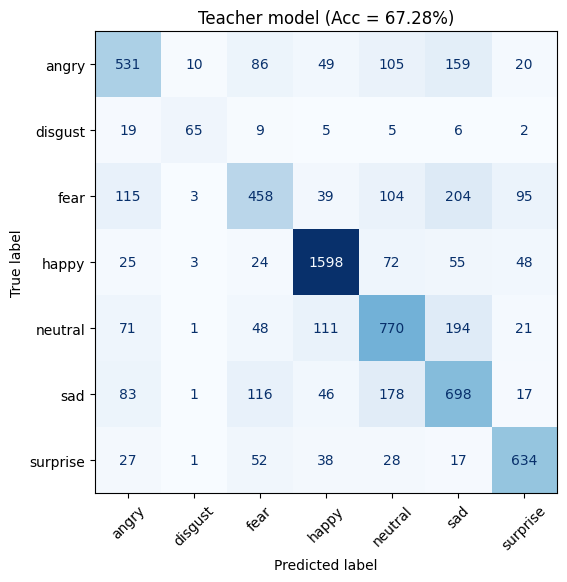

In [ ]:
class_names = val_df['classes'].unique()
y_true = np.array(numeric_labels_val)
predictions = model_b0.predict(val_ds)
val_preds = np.argmax(predictions, axis=1)

accuracy_teacher = accuracy_score(y_true, val_preds)

# Confusion Matrix
cm = confusion_matrix(y_true, val_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
ax.set_title(f"Teacher model (Acc = {accuracy_teacher:.2%})")

Таким образом, модель неплохо научилась различать эмоции и даже малочисленный класс disgust также хорошо выучился. На этом закнчим обучение и перейдем к квантованию и дистилляции.

## Дистилляция модели

Сначала дистиллируем базовую модель EfficientNetB0 в MobileNetV3Large. Далее квантизуем модель-ученика MobileNetV3.

In [ ]:
def make_student_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = tf.keras.layers.Lambda(
        lambda img: tf.keras.applications.mobilenet_v3.preprocess_input(img)
    )(inputs)

    base_student = tf.keras.applications.MobileNetV3Large(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet'
    )

    x = base_student(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes)(x) # Логиты (без softmax для дистилляции)

    return tf.keras.Model(inputs, outputs, name="student")

student_model = make_student_model(IMG_SIZE, NUM_CLASSES)

In [ ]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def call(self, x):
        return self.student(x)

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    @tf.function
    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            teacher_predictions = tf.cast(teacher_predictions, tf.float32)
            student_predictions = tf.cast(student_predictions, tf.float32)
            student_loss = self.student_loss_fn(y, student_predictions)

            p_teacher = tf.nn.softmax(teacher_predictions / self.temperature, axis=1)
            log_p_student = tf.nn.log_softmax(student_predictions / self.temperature, axis=1)

            distillation_loss = -tf.reduce_sum(p_teacher * log_p_student, axis=1)
            distillation_loss = tf.reduce_mean(distillation_loss)

            loss = self.alpha * student_loss + (1 - self.alpha) * (self.temperature**2) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": loss, "student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    @tf.function
    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)

        loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": loss})

        return results

Наблюдалась проблема в том, что  структура модели teacher_model не совпадала со структурой, которая была в момент сохранения. Поэтому было необходимо взять правильные имена слоев и убедиться в правильном выходе учителя:

In [ ]:
last_layer_name = model_b0.layers[-1].name
print(f"Последний слой называется: {last_layer_name}")

teacher_logits_model = tf.keras.Model(
    inputs=model_b0.input,
    outputs=model_b0.get_layer(last_layer_name).output
)

teacher_logits_model.layers[-1].activation = tf.keras.activations.linear

# Теперь проверяем снова
import numpy as np
test_input = np.random.random((1, IMG_SIZE, IMG_SIZE, 3)).astype("float32")
print("НОВАЯ форма выхода учителя:", teacher_logits_model(test_input).shape)

Последний слой называется: dense
НОВАЯ форма выхода учителя: (1, 7)


In [ ]:
student_checkpoint_filename = 'best_student_mobilenet.weights.h5'
student_checkpoint_filepath = os.path.join(CHECKPOINT_DIR, student_checkpoint_filename)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=student_checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

distillation_callbacks = [
    checkpoint_callback,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)
]
print(f"Веса лучшего ученика будут сохранены здесь: {student_checkpoint_filepath}")

Веса лучшего ученика будут сохранены здесь: ./model_checkpoints/best_student_mobilenet.weights.h5


In [ ]:
distiller = Distiller(student=student_model, teacher=teacher_logits_model)
distiller.build((None, IMG_SIZE, IMG_SIZE, 3))
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.7,
    temperature=1
)

In [ ]:
distiller.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=distillation_callbacks
)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - sparse_categorical_accuracy: 0.7092 - distillation_loss: 0.9547 - loss: 0.8583 - student_loss: 0.8170
Epoch 1: finished saving model to ./model_checkpoints/best_student_mobilenet.weights.h5
451/451 ━━━━━━━━━━━━━━━━━━━━ 120s 228ms/step - sparse_categorical_accuracy: 0.5780 - distillation_loss: 0.7256 - loss: 0.8969 - student_loss: 0.9703 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - sparse_categorical_accuracy: 0.7763 - distillation_loss: 0.9061 - loss: 0.7360 - student_loss: 0.6631
Epoch 2: finished saving model to ./model_checkpoints/best_student_mobilenet.weights.h5
451/451 ━━━━━━━━━━━━━━━━━━━━ 101s 224ms/step - sparse_categorical_accuracy: 0.5453 - distillation_loss: 0.9178 - loss: 0.6671 - student_loss: 0.5596 - val_loss: 0.3272 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - sparse_categorical_accuracy: 0.8512 - distillation_loss: 0.8828 - lo

Продолжаем обучение с другим learning rate, alpha и temperature.

In [ ]:
for inputs, _ in train_ds.take(1):
    _ = student_model(inputs)
student_model.load_weights(
        student_checkpoint_filepath,
        skip_mismatch=True
    )
distiller = Distiller(student=student_model, teacher=teacher_logits_model)
distiller.build((None, IMG_SIZE, IMG_SIZE, 3))
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=3  # Указываем новое значение температуры здесь
)

In [ ]:
distiller.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=distillation_callbacks
)

Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - sparse_categorical_accuracy: 0.7254 - distillation_loss: 1.5368 - loss: 11.2119 - student_loss: 0.7338
Epoch 1: finished saving model to ./model_checkpoints/best_student_mobilenet.weights.h5
451/451 ━━━━━━━━━━━━━━━━━━━━ 131s 255ms/step - sparse_categorical_accuracy: 0.6217 - distillation_loss: 1.5360 - loss: 11.1932 - student_loss: 0.6713 - val_loss: 0.7957 - learning_rate: 5.0000e-05
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - sparse_categorical_accuracy: 0.7207 - distillation_loss: 1.5358 - loss: 11.2042 - student_loss: 0.7309
Epoch 2: finished saving model to ./model_checkpoints/best_student_mobilenet.weights.h5
451/451 ━━━━━━━━━━━━━━━━━━━━ 115s 255ms/step - sparse_categorical_accuracy: 0.6309 - distillation_loss: 1.6348 - loss: 11.9374 - student_loss: 0.8331 - val_loss: 0.7808 - learning_rate: 5.0000e-05
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - sparse_categorical_accuracy: 0.7312 - distillation_loss:

In [ ]:
student_model.load_weights(student_checkpoint_filepath, skip_mismatch=True)

In [ ]:
distiller = Distiller(student=student_model, teacher=teacher_logits_model)
distiller.build((None, IMG_SIZE, IMG_SIZE, 3))
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.2,
    temperature=3  # Указываем новое значение температуры здесь
)

# Загружаем веса в дистиллятор
distiller.load_weights(student_checkpoint_filepath)

In [ ]:
results = distiller.evaluate(val_ds)
accuracy_stud = list(results[1].values())[0]
print(f"Итоговая точность студента: {accuracy * 100:.2f}%")
print(f'Точность по сравнению с моделью учителем упала на {(accuracy_teacher-accuracy_stud) * 100:.2f}%')

111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - sparse_categorical_accuracy: 0.6567 - loss: 0.6772
Итоговая точность студента: 65.67%
Точность по сравнению с моделью учителем упала на 1.61%


Итак, нам удалось удачно дистиллировать модель с потерей accuracy всего в 0,161. Далее квантизуем модель ученика.

## Квантизация модели

Т.к. была проблема с автоматическим доставанием слоев из модели, было принято решение пересоздать модель с названиями непосредственно из структуры. При этом предобработку данных отправляем в дата генератор.

In [ ]:
student_model.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         6,727 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,003,079 (11.46 MB)

 Trainable params: 2,978,679 (11.36 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [ ]:
base_mobile = student_model.get_layer('MobileNetV3Large')
pooling_layer = student_model.get_layer('global_average_pooling2d_1')
dense_layer = student_model.get_layer('dense_1')

# Собираем  модель для TFLite
inputs_clean = tf.keras.Input(shape=(224, 224, 3), name="input_layer_3", dtype=tf.float32)
x = base_mobile(inputs_clean, training=False)
x = pooling_layer(x)
new_dense = tf.keras.layers.Dense(7, name='dense_fixed', dtype='float32') # Явно указываем float32
x = new_dense(x)
new_dense.set_weights(dense_layer.get_weights())

outputs_clean = tf.keras.layers.Activation('softmax', dtype='float32')(x)

model_to_quantize = tf.keras.Model(inputs_clean, outputs_clean)

In [ ]:
# def representative_data_gen():
#     print("Начинаю калибровку...")
#     for data in tqdm(val_ds.unbatch().take(100), total=100, desc="Квантование"):
#         image = data[0]
#         image = tf.cast(image, tf.float32)
#         image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
#         image = tf.expand_dims(image, 0)

#         yield [image]

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

In [ ]:
input_shape_no_batch = (224, 224, 3)

inputs = tf.keras.Input(shape=input_shape_no_batch, batch_size=1)
outputs = model_to_quantize(inputs)
pure_keras_model = tf.keras.Model(inputs, outputs)

  Архитектура converter переделывалась много раз из-за ошибки делегата XNNPACK. Проблема несовместимости решилась переключением типа квантования с полного целочисленного на квантование только весов (удалели converter.representative_dataset = representative_data_gen).

In [ ]:
tf.keras.backend.set_floatx('float32')

converter = tf.lite.TFLiteConverter.from_keras_model(pure_keras_model)

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
try:
    tflite_model = converter.convert()
    with open('keras_mobilenet_v3_quant.tflite', 'wb') as f:
        f.write(tflite_model)
    print("Готово! Модель успешно сохранена.")
except Exception as e:
    print(f"Ошибка при конвертации: {e}")

INFO:tensorflow:Assets written to: /tmp/tmp_5qfivot/assets


INFO:tensorflow:Assets written to: /tmp/tmp_5qfivot/assets


Saved artifact at '/tmp/tmp_5qfivot'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 224, 224, 3), dtype=tf.float32, name='keras_tensor_909')
Output Type:
  TensorSpec(shape=(1, 7), dtype=tf.float32, name=None)
Captures:
  140604279208464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540981520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540981712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540980752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540982672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540980560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540981904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540982480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540980944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540983632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140603540983056:

W0000 00:00:1766507401.818715    1569 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1766507401.818757    1569 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


In [ ]:
def evaluate_tflite_model(tflite_path, dataset):
    """
    Полная проверка точности TFLite модели на датасете с использованием метрик Keras.
    """

    interpreter = tf.lite.Interpreter(
    model_path=tflite_path,
    experimental_delegates=[])

    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    print(f"Начинаю оценку модели: {tflite_path}...")

    for images, labels in tqdm(dataset, desc="Оценка"):
        for i in range(images.shape[0]):
            # Подготовка одного изображения
            img = images[i:i+1]
            img = tf.cast(img, tf.float32)
            img = tf.keras.applications.mobilenet_v3.preprocess_input(img)

            # Запуск инференса
            interpreter.set_tensor(input_details['index'], img)
            interpreter.invoke()

            output_data = interpreter.get_tensor(output_details['index'])
            accuracy_metric.update_state(labels[i:i+1], output_data)

    final_acc = accuracy_metric.result().numpy()
    return final_acc

In [ ]:
PATH_TO_TFLITE = 'keras_mobilenet_v3_quant.tflite'
accuracy_stud_quant = evaluate_tflite_model(PATH_TO_TFLITE, val_ds)
print(f"\n" + "="*30)
print(f"ИТОГОВАЯ ТОЧНОСТЬ: {accuracy_stud_quant * 100:.2f}%")
print("="*30)


Начинаю оценку модели: keras_mobilenet_v3_quant.tflite...


Оценка: 100%|█████████████████████████████████████████████████████████████████████████| 111/111 [01:04<00:00,  1.72it/s]


ИТОГОВАЯ ТОЧНОСТЬ: 65.34%


## Сравнение потребления памяти и скорости работы моделей

Сравним по данным характеристикам модели учителя EfficientNetB0, ученика MobileNet_V3 и квантизированного ученика.

In [ ]:
model_b0.save_weights(fine_tune_checkpoint_filepath)
student_model.save_weights('student_weights.weights.h5')

# Измеряем размер
teacher_w_size = os.path.getsize(fine_tune_checkpoint_filepath) / (1024 * 1024)
student_w_size = os.path.getsize('student_weights.weights.h5') / (1024 * 1024)

print(f"Чистый вес учителя (float32): {teacher_w_size:.2f} MB")
print(f"Чистый вес ученика (float32): {student_w_size:.2f} MB")
print(f"Размер квант. ученика (TFLite): {get_file_size('keras_mobilenet_v3_quant.tflite'):.2f} MB")

Чистый вес учителя (float32): 16.09 MB
Чистый вес ученика (float32): 11.94 MB
Размер квант. ученика (TFLite): 3.14 MB


In [ ]:
test_image = np.random.rand(1, 224, 224, 3).astype(np.float32)

def benchmark_keras(model, image, name, iterations=100):
    # Разогрев (первый запуск всегда долгий)
    model.predict_on_batch(image)

    start_time = time.time()
    for _ in range(iterations):
        model.predict(image, verbose=0)
    end_time = time.time()

    avg_time = (end_time - start_time) / iterations * 1000 # в миллисекунды
    print(f"[{name}] Среднее время: {avg_time:.2f} мс")
    return avg_time

def benchmark_tflite(model_path, image, iterations=100):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Разогрев
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()

    start_time = time.time()
    for _ in range(iterations):
        interpreter.set_tensor(input_details[0]['index'], image)
        interpreter.invoke()
    end_time = time.time()

    avg_time = (end_time - start_time) / iterations * 1000
    print(f"[TFLite Quant] Среднее время: {avg_time:.2f} мс")
    return avg_time

# Запускаем тесты
print("Начинаю замеры скорости (инференс)...")
time_teacher = benchmark_keras(model_b0, test_image, "Учитель B0")
time_student = benchmark_keras(student_model, test_image, "Ученик MobileNetV3")
time_quant = benchmark_tflite('keras_mobilenet_v3_quant.tflite', test_image)

# Считаем ускорение
speedup = time_teacher / time_quant
print(f"\nИтог: Квантованная модель быстрее учителя в {speedup:.1f} раз!")

Начинаю замеры скорости (инференс)...
[Учитель B0] Среднее время: 48.96 мс
[Ученик MobileNetV3] Среднее время: 50.51 мс
[TFLite Quant] Среднее время: 4.82 мс

Итог: Квантованная модель быстрее учителя в 10.2 раз!


In [ ]:
print(f"Accuracy учителя: {accuracy_teacher* 100:.2f}%")
print(f"Accuracy ученика: {accuracy_stud* 100:.2f}%")
print(f"Accuracy квантизованного ученика: {accuracy_stud_quant*100:.2f}%")

Accuracy учителя: 67.28%
Accuracy ученика: 65.67%
Accuracy квантизованного ученика: 65.34%


In [ ]:
data = {
    "Модель": ["Учитель EfficientNetB0", "Ученик MobileNetV3", "Квантизованный ученик"],
    "Память": ['16.09 MB', '11.94 MB', '3.14 MB'],
    "Скорость": ['48.96 мс', '50.51 мс', '4.82 мс'],
    "Accuracy": ['67.28%', '65.67%', '65.34%']

}

print(tabulate(data, headers="keys", tablefmt="double_grid"))

╔════════════════════════╦══════════╦════════════╦════════════╗
║ Модель                 ║ Память   ║ Скорость   ║ Accuracy   ║
╠════════════════════════╬══════════╬════════════╬════════════╣
║ Учитель EfficientNetB0 ║ 16.09 MB ║ 48.96 мс   ║ 67.28%     ║
╠════════════════════════╬══════════╬════════════╬════════════╣
║ Ученик MobileNetV3     ║ 11.94 MB ║ 50.51 мс   ║ 65.67%     ║
╠════════════════════════╬══════════╬════════════╬════════════╣
║ Квантизованный ученик  ║ 3.14 MB  ║ 4.82 мс    ║ 65.34%     ║
╚════════════════════════╩══════════╩════════════╩════════════╝
